# Ingredient-Based Clustering of Pinoy Dishes

The ambition is to identify clusters of Filipino dishes based on their ingredients. The results can be used to define the most common ingredients of a Filipino pantry. This project leverages techniques from data mining, natural language processing, and unsupervised learning. The dataset is a collection of Filipino recipes from various online recipe websites. The dataset contains the name, ingredients, and instructions of the recipes. 

## Data loading and preview

### Read JSON files

In [1]:
import json
import os


def load_recipes(path="data/recipes"):
    """Combines all recipe data into a single list."""
    files = [file for file in os.listdir(path)]

    recipes = []
    for file in files:
        file_path = os.path.join(path, file)
        with open(file_path, encoding="utf-8") as f:
            recipe_data = json.load(f)
            recipes.extend(recipe_data)

    return recipes


recipes = load_recipes()
recipes[0]

{'link': 'https://www.kawalingpinoy.com/cheese-cupcakes/',
 'name': 'Cheese Cupcakes',
 'ingredients': ['flour, sifted',
  'baking powder',
  'salt',
  'butter, softened',
  'sugar',
  'eggs',
  '(14 ounces) sweetened condensed milk',
  'quick-melt cheese, shredded',
  'cheddar cheese, shredded'],
 'instructions': ['Line muffin pan with cupcake liners.',
  'In a large bowl, combine flour, baking powder,\xa0and salt.',
  'In a medium bowl, beat butter, sugar, and eggs with an electric mixer until combined.',
  'Beginning and ending with flour mixture, add flour mixture in thirds and ½ of sweetened condensed milk in between (⅓ flour mixture, ½ condensed milk, ⅓ flour mixture, ½ condensed milk and ⅓ flour mixture) to egg mixture. Beat at low speed with every addition.',
  'Add quick-melt cheese and stir to combine.',
  'Using a scoop or spoon, fill each muffin hole up to ¾ full. Top with cheddar cheese.',
  'Bake in a 350 F oven for about 20 to 25 minutes or until a toothpick inserted com

### Convert JSON to DataFrame

In [2]:
import pandas as pd


recipe_df = pd.DataFrame(recipes)
recipe_df.head()

,link,name,ingredients,instructions
0,https://www.kawalingpinoy.com/cheese-cupcakes/,Cheese Cupcakes,"[flour, sifted, baking powder, salt, butter, s...","[Line muffin pan with cupcake liners., In a la..."
1,https://www.kawalingpinoy.com/adobong-sitaw-wi...,Adobong Sitaw with Pork,"[canola oil, pork belly, cut into thin strips,...","[In a skillet over medium heat, heat oil. Add ..."
2,https://www.kawalingpinoy.com/burger-steak/,Burger Steak,"[white bread, torn into small pieces, beef bro...","[In a small bowl, soak bread in broth. Tear wi..."
3,https://www.kawalingpinoy.com/chicken-menudo/,Chicken Menudo,"[canola oil, red bell pepper, cored, seeded an...","[In a wide pan over medium heat, heat 1 tables..."
4,https://www.kawalingpinoy.com/beef-salpicao/,Beef Salpicao,"[ribeye steak, cut into 1-inch cubes, salt and...","[In a bowl, season beef with salt and pepper t..."


In [3]:
recipe_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2815 entries, 0 to 2814
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   link          2815 non-null   object
 1   name          2469 non-null   object
 2   ingredients   2469 non-null   object
 3   instructions  2469 non-null   object
dtypes: object(4)
memory usage: 88.1+ KB


### Display some statistics

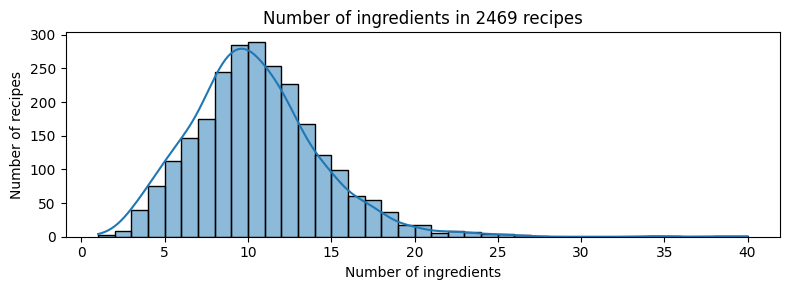

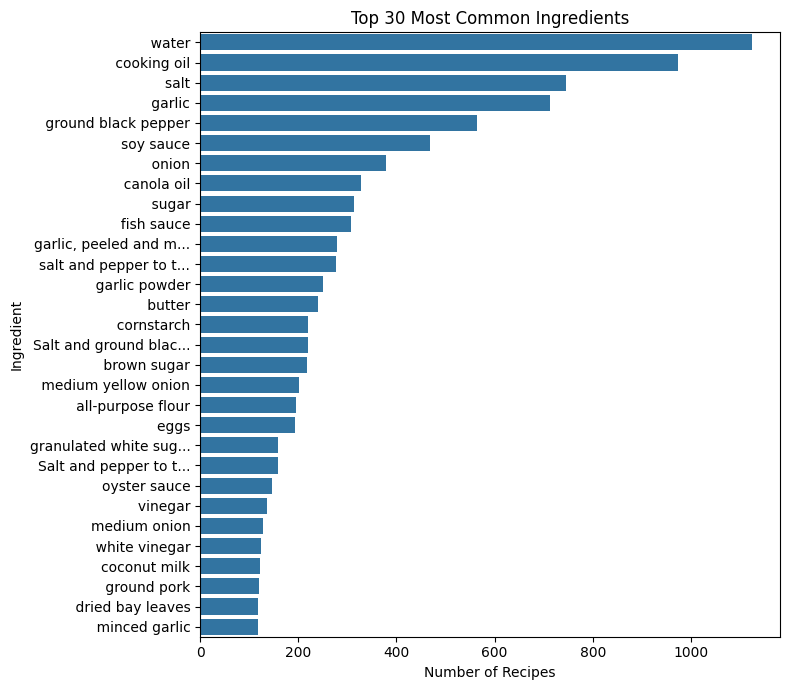

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns


def plot_ingredient_count_distribution(ingredient_series, figsize=(8, 3)):
    """Plots the distribution of the number of ingredients in recipes."""
    counts = ingredient_series.dropna().apply(len)
    plt.figure(figsize=figsize)
    sns.histplot(counts, kde=True, binwidth=1)
    plt.title(f"Number of ingredients in {len(counts)} recipes")
    plt.xlabel("Number of ingredients")
    plt.ylabel("Number of recipes")
    plt.tight_layout()
    plt.show()


def plot_common_ingredients(
    ingredient_series, n=30, most_common=True, figsize=(8, 7)
):
    """Plots the most or least common ingredients."""
    all_ingredients = ingredient_series.dropna().explode()
    ingredient_counts = all_ingredients.value_counts()

    if most_common:
        top_n_ingredients = ingredient_counts.head(n)
    else:
        top_n_ingredients = ingredient_counts.tail(n)

    ylabels = [
        f"{i[:20]:>20}{'...' if len(i) > 20 else ''}"
        for i in top_n_ingredients.index
    ]
    plt.figure(figsize=figsize)
    sns.barplot(x=top_n_ingredients.values, y=ylabels)
    indicator = "Most" if most_common else "Least"
    plt.title(f"Top {n} {indicator} Common Ingredients")
    plt.xlabel("Number of Recipes")
    plt.ylabel("Ingredient")
    plt.tight_layout()
    plt.show()


plot_ingredient_count_distribution(recipe_df.ingredients)
plot_common_ingredients(recipe_df.ingredients, n=30, most_common=True)

## Preprocessing


### Remove recipes with no ingredients

In [5]:
recipe_df = recipe_df.dropna(subset=["ingredients"])
recipe_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2469 entries, 0 to 2814
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   link          2469 non-null   object
 1   name          2469 non-null   object
 2   ingredients   2469 non-null   object
 3   instructions  2469 non-null   object
dtypes: object(4)
memory usage: 96.4+ KB


### Clean ingredient format

In [6]:
import re

from tqdm import tqdm

tqdm.pandas()


def remove_parentheses(ingredient):
    """Removes parentheses and content from ingredient strings."""
    return re.sub(r" ?\([^)]+\)", "", ingredient)


def select_first_option(ingredient):
    """Selects the first option in a string with multiple options."""
    return ingredient.split(" or ")[0]


def clean_ingredient(ingredient):
    """Cleans an ingredient string."""
    ingredient = remove_parentheses(ingredient)
    ingredient = select_first_option(ingredient)
    return ingredient.lower().strip()


recipe_df["clean_ingredients"] = recipe_df.ingredients.progress_apply(
    lambda x: [clean_ingredient(i) for i in x]
)

100%|██████████| 2469/2469 [00:00<00:00, 91511.68it/s]


### Lemmatize words and remove non-ingredient words

In [7]:
import spacy

nlp = spacy.load("en_core_web_lg")


def correct_noun_pos_tags(token):
    """Corrects the POS tags of specific tokens."""
    outliers = ["cauliflower", "baking"]
    if token.text in outliers:
        token.pos_ = "NOUN"
    return token


def lemmatize_nouns(ingredient):
    """Lemmatizes nouns in an ingredient string."""
    doc = nlp(ingredient)
    lemmas = []
    for token in doc:
        token = correct_noun_pos_tags(token)
        if (
            token.is_alpha
            and not token.is_stop
            and token.pos_ in ["NOUN", "PROPN"]
        ):
            lemmas.append(token.lemma_)
    return " ".join(lemmas)


recipe_df["lemmatized"] = recipe_df.clean_ingredients.progress_apply(
    lambda x: [lemmatized for i in x if (lemmatized := lemmatize_nouns(i))]
)

100%|██████████| 2469/2469 [01:27<00:00, 28.12it/s]


### Remove stop words related to culinary

In [8]:
with open(f"data/stopwords.txt") as file:
    stopwords = file.read().splitlines()


def filter_stopwords(text):
    """Filter out stopwords from a string."""
    words = []
    for word in text.split():
        if word not in stopwords:
            words.append(word)
    return " ".join(words)


recipe_df["filtered"] = recipe_df.lemmatized.progress_apply(
    lambda x: [filtered for i in x if (filtered := filter_stopwords(i))]
)

100%|██████████| 2469/2469 [00:00<00:00, 23229.04it/s]


### Standardize ingredient names at word level

In [9]:
# TODO: Separate thesaurus for word and phrase level
with open("data/thesaurus.json") as file:
    thesaurus = json.load(file)


def standardize_at_phrase_level(ingredient):
    """Replace words in an ingredient with standard names."""
    words = []
    for word in ingredient.split():
        words.append(thesaurus.get(word, word))
    return " ".join(words)


recipe_df["standardized_word"] = recipe_df.filtered.progress_apply(
    lambda x: [
        common_name
        for i in x
        if (common_name := standardize_at_phrase_level(i))
    ]
)

100%|██████████| 2469/2469 [00:00<00:00, 274345.95it/s]


### Remove duplicate terms

In [10]:
def remove_duplicates(text):
    """Remove duplicate terms while preserving order."""
    seen = set()
    unique = []
    for word in text.split():
        if word not in seen:
            unique.append(word)
            seen.add(word)
    return " ".join(unique)


recipe_df["unique"] = recipe_df.standardized_word.progress_apply(
    lambda x: [unique for i in x if (unique := remove_duplicates(i))]
)

100%|██████████| 2469/2469 [00:00<00:00, 224310.36it/s]


### Standardize ingredient names at phrase level

In [11]:
def standardize_at_phrase_level(ingredient):
    """Replace the whole ingredient string with a standard name."""
    return thesaurus.get(ingredient, ingredient)


recipe_df["standardized_phrase"] = recipe_df.unique.progress_apply(
    lambda x: [
        standardized
        for i in x
        if (standardized := standardize_at_phrase_level(i))
    ]
)

100%|██████████| 2469/2469 [00:00<00:00, 493882.90it/s]


### Break down ingredients into basic components

In [12]:
with open("data/components.json") as file:
    ingredient_components = json.load(file)


def break_down_ingredient(ingredient):
    """Breaks down an ingredient into its components."""
    components = ingredient_components.get(ingredient, ingredient)
    if isinstance(components, str):
        return [components]
    return components


recipe_df["components"] = recipe_df.standardized_phrase.progress_apply(
    lambda x: [component for i in x for component in break_down_ingredient(i)]
)

100%|██████████| 2469/2469 [00:00<00:00, 411399.04it/s]


In [13]:
ingredients = sorted(
    recipe_df
    .components
    .explode()
    .unique()
    .astype(str)
    .tolist()
)

with open("data/cleaned.txt", "w") as file:
    file.write("\n".join(ingredients))

### Remove rare ingredients

In [14]:
counts = recipe_df.components.explode().value_counts()

with open("data/counts.json", "w") as file:
    json.dump(counts.to_dict(), file, indent=2)

raise ValueError("Stop here for now.")

ValueError: Stop here for now.

In [ ]:
MIN_INGREDIENT_COUNT = 5

rare_ingredients = counts[counts <= MIN_INGREDIENT_COUNT].index


def remove_rare_ingredient(ingredient):
    """Removes rare ingredients from a list."""
    return ingredient if ingredient not in rare_ingredients else None


recipe_df["frequent"] = recipe_df.standardized.apply(
    lambda x: [remove_rare_ingredient(i) for i in x]
)

In [ ]:
plot_ingredient_count_distribution(recipe_df.standardized)

### Remove recipes with too few or too many ingredients

In [ ]:
# TODO: Get the 3rd quartile minus 1st quartile (75%)
MIN_INGREDIENTS_IN_RECIPE = 4
MAX_INGREDIENTS_IN_RECIPE = 9

counts = recipe_df.common_names.apply(len)
recipe_df = recipe_df[
    (counts >= MIN_INGREDIENTS_IN_RECIPE)
    & (counts <= MAX_INGREDIENTS_IN_RECIPE)
]

### Add flavor tags to ingredients

In [ ]:
with open("data/flavor_map.json") as file:
    flavor_map = json.load(file)


def map_ingredient_to_flavor(ingredient):
    """Maps an ingredient to a flavor."""
    flavor = flavor_map.get(ingredient, "")
    if flavor == "flavorless":
        return ingredient
    return f"{flavor} {ingredient}"


recipe_df["with_flavors"] = recipe_df.common_names.progress_apply(
    lambda x: [map_ingredient_to_flavor(i) for i in x]
)

## Vectorization


In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-mpnet-base-v2")
ingredients_as_texts = [
    " ".join(sorted(ingredients))
    for ingredients in recipe_df["cleaned_ingredients"]
]
embeddings = model.encode(
    ingredients_as_texts,
    show_progress_bar=True,
)

In [ ]:
embeddings.shape

## Dimensionality reduction

In [ ]:
from sklearn.decomposition import TruncatedSVD

dimensions_to_keep = 2
svd = TruncatedSVD(n_components=dimensions_to_keep)
reduced_embeddings = svd.fit_transform(embeddings)

## Clustering


In [ ]:
from sklearn.cluster import AgglomerativeClustering

n_clusters = 7
clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage="ward")
cluster_labels = clustering.fit_predict(reduced_embeddings)

## Visualization


In [ ]:
import plotly.express as px
import pandas as pd


def plot_clusters_3d(reduced_embeddings, cluster_labels, recipe_df):
    """Plots a 3D scatter plot of recipe clusters."""

    final_df = pd.DataFrame(
        {
            "x": reduced_embeddings[:, 0],
            "y": reduced_embeddings[:, 1],
            # "z": reduced_embeddings[:, 2],
            "cluster": cluster_labels.astype(str),
            "recipe_name": recipe_df["name"],
            "cleaned_ingredients": [
                "<br>".join(ingredients)
                for ingredients in recipe_df["cleaned_ingredients"]
            ],
        }
    )

    fig = px.scatter(
        final_df,
        x="x",
        y="y",
        # z="z",
        color="cluster",
        hover_name="recipe_name",
        hover_data=["cleaned_ingredients"],
        width=800,
        height=1000,
        color_discrete_sequence=px.colors.qualitative.Bold,
    )

    fig.update_traces(marker=dict(size=5))
    fig.update_layout(title="Ingredient-Based Clustering of Filipino Dishes")

    unique_clusters = final_df["cluster"].unique()
    buttons = [
        dict(
            label=f"Cluster {cluster}",
            method="update",
            args=[
                {"visible": [cluster == c for c in unique_clusters]},
                {"title": f"Ingredient-Based Clustering - Cluster {cluster}"},
            ],
        )
        for cluster in unique_clusters
    ]
    fig.update_layout(
        updatemenus=[
            dict(
                type="buttons",
                direction="down",
                buttons=buttons,
            )
        ]
    )

    fig.show()


plot_clusters_3d(reduced_embeddings, cluster_labels, reduced_df)